In [1]:
from pymilvus import MilvusClient

# Kết nối tới Milvus server
milvus_client = MilvusClient(uri="http://localhost:19530")

# Kiểm tra kết nối bằng cách liệt kê collection
try:
    collections = milvus_client.list_collections()
    print("Kết nối thành công! Danh sách collection:", collections)
except Exception as e:
    print("Kết nối thất bại:", str(e))

Kết nối thành công! Danh sách collection: []


In [2]:
# Tạo collection
collection_name = "image_collection"

# Xóa collection nếu đã tồn tại (nếu muốn bắt đầu lại)
if milvus_client.has_collection(collection_name):
    milvus_client.drop_collection(collection_name)

# Tạo collection mới
milvus_client.create_collection(
    collection_name=collection_name,
    dimension=512,  # Chiều dài vector từ CLIP (ViT-B/32)
    auto_id=True,   # Tự động tạo ID
    enable_dynamic_field=True,  # Hỗ trợ field động (như filepath)
)

# Kiểm tra lại danh sách collection
collections = milvus_client.list_collections()
print("Danh sách collection:", collections)

Danh sách collection: ['image_collection']


In [3]:
# -------------------------
# 1. Import thư viện cần thiết
# -------------------------
import clip                      # Thư viện CLIP từ OpenAI để encode image & text thành vector
from PIL import Image            # Dùng để mở & xử lý ảnh

# -------------------------
# 2. Tải mô hình CLIP
# -------------------------
model_name = "ViT-B/32"          # Chọn kiến trúc mô hình CLIP (Vision Transformer B/32)
model, preprocess = clip.load(model_name)   # Tải mô hình và hàm tiền xử lý ảnh
model.eval()                     # Đặt mô hình về chế độ "evaluation" (không train, chỉ inference)

# ---------------------------------------
# 3. Hàm mã hóa ảnh thành vector
# ---------------------------------------
def encode_image(image_path):
    """
    Input:  image_path (đường dẫn ảnh, ví dụ: 'cat.jpg')
    Output: vector 512 chiều biểu diễn nội dung ảnh
    """
    image = preprocess(Image.open(image_path)).unsqueeze(0)   # (a) mở ảnh, (b) tiền xử lý, (c) thêm batch dimension
    image_features = model.encode_image(image)                # Cho ảnh qua CLIP → nhận embedding vector
    image_features /= image_features.norm(dim=-1, keepdim=True)  # Chuẩn hóa vector về độ dài 1 (normalize)
    return image_features.squeeze().tolist()   # Trả về dạng list Python (thay vì tensor)

# ---------------------------------------
# 4. Hàm mã hóa text thành vector
# ---------------------------------------
def encode_text(text):
    """
    Input:  text (chuỗi văn bản, ví dụ: 'a cute cat')
    Output: vector 512 chiều biểu diễn nội dung văn bản
    """
    text_tokens = clip.tokenize(text)          # Biến text thành token để mô hình CLIP hiểu
    text_features = model.encode_text(text_tokens)  # Cho text qua CLIP → nhận embedding vector
    text_features /= text_features.norm(dim=-1, keepdim=True)  # Chuẩn hóa vector về độ dài 1
    return text_features.squeeze().tolist()   # Trả về dạng list Python


d:\Big_project_2025\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Ingestion

In [4]:
import os
from glob import glob

image_dir = "D:/Big_project_2025/WebShop/app/static" # Thư mục chứa ảnh (dataset)
raw_data = []  # Danh sách lưu vector + đường dẫn ảnh
batch_size = 10  # Giảm xuống 10 ảnh/lần

for image_path in glob(os.path.join(image_dir, "**/*.png")): # Duyệt tất cả ảnh đuôi .PNG (bao gồm sub-folder)
    image_embedding = encode_image(image_path) # Mã hóa ảnh thành vector bằng CLIP
    image_dict = {"vector": image_embedding, "filepath": image_path}
    raw_data.append(image_dict)
    
    if len(raw_data) >= batch_size:
        insert_result = milvus_client.insert(collection_name="image_collection", data=raw_data) # Tên collection trong Milvus
        print(f"Đã chèn {insert_result['insert_count']} ảnh.")
        raw_data = []  # Reset danh sách

# Chèn phần còn lại
if raw_data:
    insert_result = milvus_client.insert(collection_name="image_collection", data=raw_data)
    print(f"Đã chèn {insert_result['insert_count']} ảnh còn lại.")

Đã chèn 10 ảnh.
Đã chèn 3 ảnh còn lại.


In [5]:
from deep_translator import GoogleTranslator

# Văn bản cần dịch
text_vi = "sofa màu trắng"

# Dịch từ Tiếng Việt sang Tiếng Anh
result = GoogleTranslator(source='vi', target='en').translate(text_vi)

# print("Tiếng Việt:", text_vi)
# print("English:", result)


query_text = result                     # Câu truy vấn (ví dụ: tìm chó Doberman)
query_embedding = encode_text(query_text)   # Mã hóa text thành vector bằng CLIP

search_results = milvus_client.search(
    collection_name="image_collection",    # Tên collection đã tạo trong Milvus
    data=[query_embedding],             # Vector query (nên để list, vì có thể search nhiều query một lúc)
    limit=2,                           # Trả về top 10 kết quả gần nhất
    output_fields=["filepath"],         # Ngoài vector similarity, trả thêm thông tin đường dẫn ảnh
)


Query text: white sofa

Search results:


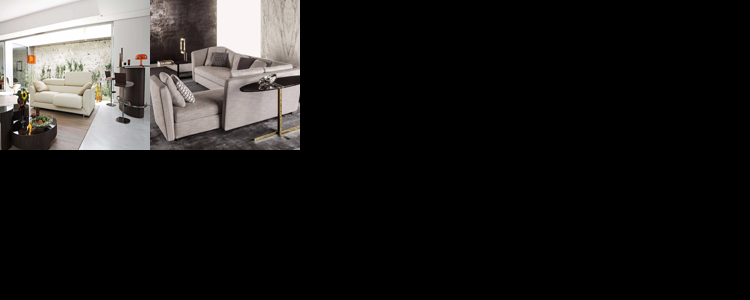

In [6]:
from IPython.display import display   # Dùng để hiển thị ảnh trực tiếp trong notebook/JupyterLab
from PIL import Image                 # Thư viện xử lý ảnh (mở, resize, ghép ảnh)

# -----------------------------
# 1. Tạo một "canvas" trống để dán kết quả tìm kiếm
# -----------------------------
width = 150 * 5     # 5 ảnh mỗi hàng, mỗi ảnh 150px
height = 150 * 2    # 2 hàng, mỗi ảnh 150px
concatenated_image = Image.new("RGB", (width, height))  
# -> Tạo 1 ảnh trắng (RGB) kích thước width × height, nơi sẽ dán kết quả

# -----------------------------
# 2. Chuẩn bị danh sách ảnh kết quả
# -----------------------------
result_images = []
for result in search_results:        # search_results chứa danh sách các kết quả Milvus trả về
    for hit in result:               # Mỗi result là 1 list các "hit" (ảnh gần nhất)
        filename = hit["entity"]["filepath"]   # Lấy đường dẫn ảnh từ metadata đã lưu trong Milvus
        img = Image.open(filename)             # Mở ảnh gốc từ filepath
        img = img.resize((150, 150))           # Resize ảnh về 150×150 để xếp vào grid
        result_images.append(img)              # Thêm ảnh vào danh sách kết quả

# -----------------------------
# 3. Dán từng ảnh kết quả vào canvas
# -----------------------------
for idx, img in enumerate(result_images):  
    x = idx % 5   # Cột (mod 5 để xuống hàng sau khi đủ 5 ảnh)
    y = idx // 5  # Hàng
    concatenated_image.paste(img, (x * 150, y * 150))  
    # Dán ảnh vào vị trí (x*150, y*150) trên canvas

# -----------------------------
# 4. In query + hiển thị ảnh kết quả
# -----------------------------
print(f"Query text: {query_text}")   # In câu query người dùng nhập
print("\nSearch results:")           # In tiêu đề
display(concatenated_image)          # Hiển thị ảnh grid chứa các kết quả tìm được


## Tổng quan về mục tiêu
Code này xây dựng một hệ thống tìm kiếm hình ảnh dựa trên văn bản (text-to-image search) bằng cách:

- dụng mô hình CLIP để tạo embedding (biểu diễn vector) cho cả văn bản và hình ảnh.
- Lưu trữ các embedding hình ảnh trong Milvus (cơ sở dữ liệu vector).
- Thực hiện tìm kiếm tương tự (similarity search) để tìm hình ảnh phù hợp với văn bản nhập vào.

# phiên bản tối ưu 
🚀 Tối ưu đã áp dụng

- ViCLIP + PhoBERT cho query tiếng Việt (# code tối ưu).

- Milvus để lưu vector ảnh.

- Query Expansion (mở rộng nghĩa cho từ khóa).

- Hybrid Retrieval = BM25 (từ khóa) + Embedding (ngữ nghĩa).

- Batch insert để tiết kiệm RAM khi index nhiều ảnh.